# 참고

- \#@ : 단순 노트
- \#@KeyNote : 핵심 개념 노트
- \#@TODO : 당장 해야할 것들

# 프로젝트: 뉴스기사 요약해보기

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


# Step 1. 데이터 수집하기

이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="../data/news_summary_more.csv")
data = pd.read_csv('../data/news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
26620,Video shows fans misbehaving with Katrina Kaif...,A video which shows Katrina Kaif being heckled...
15794,Falahari Baba given life imprisonment for rapi...,"Falahari Baba, a self-styled godman was senten..."
26569,Tesla's new factory in China to produce 5 lakh...,Tesla on Tuesday reached an agreement with Sha...
14395,20 die as limo carrying wedding party crashes ...,As many as 20 people were killed when a limous...
14255,2 Vyapam scam whistleblowers to contest Madhya...,"Two Vyapam scam whistleblowers, namely Dr Anan..."
22594,Mehbooba Mufti replies to Omar Abdullah with l...,Responding to former Jammu and Kashmir CM Omar...
7116,"9-year-old boy drops to floor, crawls out of r...","A video shows a 9-year-old boy, who was overwh..."
66871,President Kovind invites people to visit Rasht...,President Ram Nath Kovind took to Twitter to i...
66280,Hayden took 10 hours to slam then highest Test...,Former Australian opener Matthew Hayden smashe...
85879,3 Indian male badminton players in top-15 for ...,For the first time in Indian badminton's histo...


In [4]:
#@KeyNote 기존 코드 활용을 쉽게 하기 위해서 이름 변경.

# 컬럼 이름 변경
data.rename(columns={'headlines': 'Summary', 'text': 'Text'}, inplace=True)

# 컬럼 순서 변경
data = data[['Text', 'Summary']]

In [5]:
# 결과 확인
data.sample(10)

,Text,Summary
44589,Amid various incidents of statue vandalism acr...,Lenin statue razing in Tripura wasn't vandalis...
57873,Social media major Facebook's Messenger report...,Facebook Messenger faces global outage: Report
79391,A five-year-old girl was fined ÃÂ£150 (Ã¢ÂÂ¹...,"Five-year-old girl fined Ã¢ÂÂ¹12,500 for runn..."
42063,"As per reports, Pooja Hegde will star in the u...",Pooja Hegde to star in Housefull 4: Reports
77906,Delhi's Department of Environment is reportedl...,Delhi government to fix rules for road dust di...
86728,Abhishek Bachchan on Instagram shared a pictur...,Abhishek posts pic from when father Amitabh wa...
12866,Advertising company Publicis India has sacked ...,Publicis India fires senior exec accused of se...
58899,While talking at IFFI 2017 about how cinema is...,"In a theatre, we never ask caste of person nex..."
17346,US President Donald Trump's former campaign ch...,Ex-Trump campaign chief pleads guilty to consp...
24946,The Bihar government led by CM Nitish Kumar wi...,Bihar to grant reservation in promotion to SC/...


In [6]:
#@ 몇 글자 뜨는지 보고 싶어서 구현
for _, row in data.sample(2).iterrows():
    print(f"[Text]         {row['Text']}\n -> {len(row['Text'])}문자\n")
    print(f"[Summary]    {row['Summary']}\n -> {len(row['Summary'])}문자")
    print("\n\n")


[Text]         Addressing an election rally in poll-bound Karnataka on Tuesday, Prime Minister Narendra Modi said that while the government talks about enhancing 'Ease of Doing Business', Congress believes in 'Ease of Doing Murder'. "This is the culture they have developed," he added. Further, talking about murders of BJP workers in the state, he said, "Violence cannot exist in a democracy."
 -> 379문자

[Summary]    Congress believes in 'Ease of Doing Murder': PM in K'taka
 -> 57문자



[Text]         Pakistan-born South African spinner Imran Tahir posted a tweet in Tamil ahead of the Indian Premier League 2018 opener on Saturday. The 39-year-old spinner, who represents Chennai Super Kings in the T20 league, shared a picture of his jersey and wrote, "ItÃ¢ÂÂs time to start the vehicle and finish the job quick. Whistle podu!"
 -> 330문자

[Summary]    Pak-born SA cricketer Tahir tweets in Tamil ahead of IPL
 -> 56문자





# Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

- Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 불용어들이 Summary에는 남아 있는 게 더 좋을 것 같음.

## 데이터 전처리하기 (1) 데이터 정리하기

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [7]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [8]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [9]:
print(data.isnull().sum())

Text       0
Summary    0
dtype: int64


In [10]:
#@ 데이터셋의 'Text' 자체에 비어있는 게 없으므로 무의미하지만, 템플릿 느낌으로 포함.
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 텍스트 정규화와 불용어 제거

정규화 사전 출처
https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [11]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [12]:
nltk.download('stopwords')

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [14]:
# 전처리 후 차이점 살펴보기
for _, row in data.sample(1).iterrows():
    print(f"=== Text:    \n    {row['Text']}\n => {preprocess_sentence(row['Text'])}")
    print(f"=== Summary:    \n    {row['Summary']}\n => {preprocess_sentence(row['Summary'])}")
    

=== Text:    
    The Madras High Court on Tuesday declined a PIL seeking to ban 'rekla race', or bullock cart race, in Tamil Nadu in view of a Supreme Court order banning such events. The state government had, however, brought in an amendment allowing 'Jallikattu'. The petitioner pointed out that the amendment only made an exception for 'Jallikattu', and not bullock cart races.
 => madras high court tuesday declined pil seeking ban rekla race bullock cart race tamil nadu view supreme court order banning events state government however brought amendment allowing jallikattu petitioner pointed amendment made exception jallikattu bullock cart races
=== Summary:    
    Madras HC refuses to ban bullock cart races in Tamil Nadu
 => madras hc refuses ban bullock cart races tamil nadu


In [15]:
# 전체 Text 데이터에 대한 전처리
clean_text = []

for sentence in data['Text']:
    #@ 불용어 제거: 텍스트 길이가 길기 때문
    processed_sentence = preprocess_sentence(sentence, remove_stopwords=True)
    clean_text.append(processed_sentence)

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:2])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit']


In [18]:
# 전체 Summary 데이터에 대한 전처리
clean_summaries = []

for sentence in data['Summary']:
    #@ 불용어 제거하지 않음: 텍스트 길이가 짧아서 주요 정보 소실될 수 있음.
    processed_sentence = preprocess_sentence(sentence, remove_stopwords=False)  
    clean_summaries.append(processed_sentence)

print("Summary 전처리 후 결과: ", clean_summaries[:2])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred']


In [20]:
data['Text'] = clean_text
data['Summary'] = clean_summaries

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [21]:
data.head()

,Text,Summary
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...


In [22]:
data.isnull().sum()

Text       0
Summary    0
dtype: int64

In [23]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 데이터 전처리하기 (2) 훈련데이터와 테스트데이터 나누기

### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


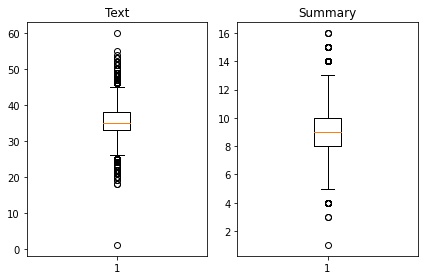

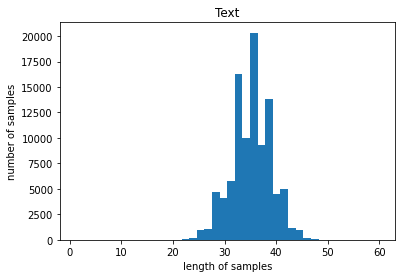

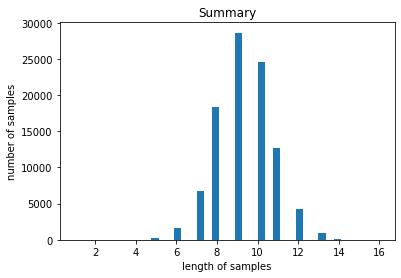

In [24]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [25]:
#@TODO: 적당한 길이 설정 필요함 (상의해봐야 함)
# 상의 결과, 3사분위 (75%: 네모 박스 윗변)에 맞추기로 함.
# 75~95%가 적절합니다. (GPT)
# 
text_max_len = 40
summary_max_len = 10

In [27]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [28]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [29]:
# 조건에 맞는 샘플만 필터링
filtered_data = data[
    data['Text'].apply(lambda x: len(x.split()) <= text_max_len) &  # Text 길이 조건
    data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)  # Summary 길이 조건
]

# 결과 출력
print(f"필터링 전 샘플 수: {len(data)}")
print(f"필터링 후 샘플 수: {len(filtered_data)}")

필터링 전 샘플 수: 98360
필터링 후 샘플 수: 74102


### 시작 토큰과 종료 토큰 추가하기

In [30]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [31]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [32]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[36344 39723 76289 ... 37558 14964 91481]


In [33]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [34]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [35]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


## 데이터 전처리하기 (3) 정수 인코딩

### 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [36]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [37]:
print(list(src_tokenizer.word_index.items())[:5])  # 단어-인덱스 맵핑 상위 5개 출력

[('said', 1), ('india', 2), ('year', 3), ('added', 4), ('us', 5)]


In [38]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69577
등장 빈도가 6번 이하인 희귀 단어의 수: 47383
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22194
단어 집합에서 희귀 단어의 비율: 68.10152780372825
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4820799050355014


22194는 추천값으로 사용할 수 있음.
학습 환경과 데이터에 따라 더 작게 (10000~15000) 또는 필요하면 더 크게 설정해 볼 수 있음.
모델 성능을 기준으로 최적값을 조정하는 것이 최선.

- 고은비: 21000
- 민혁: 15000
- 임만순: 21000

다수결의 원칙 적용

In [39]:
src_vocab = 21000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 21,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [40]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[38, 729, 3311, 8018, 1, 3, 13, 64, 443, 5713, 10, 1631, 3177, 14233, 994, 64, 113, 2056, 475, 556, 75, 798, 747, 1016, 9, 8136, 95, 227, 91, 52, 1878, 1617, 158, 251, 180], [561, 3368, 2379, 20737, 207, 2496, 1334, 4047, 111, 975, 300, 489, 2785, 740, 20737, 2565, 2399, 284, 121, 300, 458, 3, 13, 3368, 2065, 43, 933, 5276, 383], [1825, 5552, 6968, 258, 821, 336, 1364, 2570, 16693, 6468, 3555, 1364, 685, 18409, 5552, 702, 5223, 969, 4469, 17519, 15994, 3555, 504, 2570, 663, 1, 4654, 5908]]


In [41]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [42]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30090
등장 빈도가 5번 이하인 희귀 단어의 수: 19676
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10414
단어 집합에서 희귀 단어의 비율: 65.3904951811233
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.644807057589685


10414는 추천값으로 사용할 수 있음.
학습 환경과 데이터에 따라 더 작게 (5000~8000) 또는 필요하면 더 크게 설정해 볼 수 있음.
모델 성능을 기준으로 최적값을 조정하는 것이 최선.

- 고은비: 5000~10000 (기권)
- 민혁: 5000~10000 (기권)
- 임만순: 8000

다수결의 원칙 적용

In [44]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 142, 170, 43, 71, 17, 3421, 359, 60, 32, 266], [1, 1941, 492, 106, 258, 3, 2864, 4, 3581, 89], [1, 4836, 3, 2230, 2042, 15, 733, 6799, 2314, 3, 83], [1, 5008, 7214, 5881, 15, 910, 356], [1, 30, 5628, 22, 37, 1881, 5, 2043, 34, 420]]
target
decoder  [[142, 170, 43, 71, 17, 3421, 359, 60, 32, 266, 2], [1941, 492, 106, 258, 3, 2864, 4, 3581, 89, 2], [4836, 3, 2230, 2042, 15, 733, 6799, 2314, 3, 83, 2], [5008, 7214, 5881, 15, 910, 356, 2], [30, 5628, 22, 37, 1881, 5, 2043, 34, 420, 2]]


In [45]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78687
훈련 레이블의 개수 : 78687
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


### 패딩하기

In [46]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

In [47]:
print("encoder_input_train: ", encoder_input_train, "\n", len(encoder_input_train), "개 (", len(encoder_input_train[0]), ")")
print("encoder_input_test: ", encoder_input_test, "\n", len(encoder_input_test), "개 (", len(encoder_input_test[0]), ")")
print("decoder_input_train: ", decoder_input_train, "\n", len(decoder_input_train), "개 (", len(decoder_input_train[0]), ")")
print("decoder_target_train: ", decoder_target_train, "\n", len(decoder_target_train), "개 (", len(decoder_target_train[0]), ")")
print("decoder_input_test: ", decoder_input_test, "\n", len(decoder_input_test), "개 (", len(decoder_input_test[0]), ")")
print("decoder_target_test: ", decoder_target_test, "\n", len(decoder_target_test), "개 (", len(decoder_target_test[0]), ")")

encoder_input_train:  [[   38   729  3311 ...     0     0     0]
 [  561  3368  2379 ...     0     0     0]
 [ 1825  5552  6968 ...     0     0     0]
 ...
 [  882  1622  5577 ...     0     0     0]
 [ 4273   303  8718 ...   794     0     0]
 [10687   944    59 ...     0     0     0]] 
 78687 개 ( 40 )
encoder_input_test:  [[ 365  196    1 ...    0    0    0]
 [ 174   10  114 ...    0    0    0]
 [  38 3734 1605 ...    0    0    0]
 ...
 [5327  676 5584 ...    0    0    0]
 [6022 3924  120 ...    0    0    0]
 [6542  923 1044 ...    0    0    0]] 
 19672 개 ( 40 )
decoder_input_train:  [[ 142  170   43 ...   60   32  266]
 [   1 1941  492 ...    4 3581   89]
 [4836    3 2230 ... 2314    3   83]
 ...
 [   1 2059 1428 ... 3096  408    0]
 [2598  178 5410 ...  116 1920 1403]
 [   1 7145  973 ... 7400  315   17]] 
 78687 개 ( 10 )
decoder_target_train:  [[ 170   43   71 ...   32  266    2]
 [1941  492  106 ... 3581   89    2]
 [   3 2230 2042 ...    3   83    2]
 ...
 [2059 1428   19 ...  408

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

## Seq2Seq (기본) 모델 설계하기

In [52]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

encoder_outputs, state_h, state_c = encoder_output3, state_h3, state_c3


In [53]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [54]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 128)      2688000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 40, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 어텐션 메커니즘

In [55]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 128)      2688000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 40, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 모델 훈련

In [93]:
# 1: 26회
# 2: 5회
# 3: 
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 29s 80ms/step - loss: 2.8666 - val_loss: 4.0226
Epoch 2/50
308/308 [==============================] - 24s 77ms/step - loss: 2.8054 - val_loss: 4.0221
Epoch 3/50
308/308 [==============================] - 24s 79ms/step - loss: 2.7645 - val_loss: 4.0252
Epoch 4/50
308/308 [==============================] - 24s 79ms/step - loss: 2.7309 - val_loss: 4.0303
Epoch 00004: early stopping


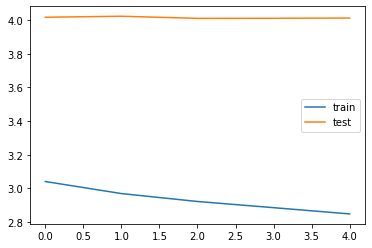

In [83]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [90]:
model.save('attention_seq2seq.h5')

In [97]:
from tensorflow.keras.models import load_model

print(load_model('attention_seq2seq.h5').predict("A British man has been captured by Russian forces while fighting for Ukraine, according to reports. In a video circulating online, a man dressed in military clothing identifies himself as James Scott Rhys Anderson, 22, and says he formerly served in the British Army."))

IndexError: list index out of range

## 인퍼런스 모델 구현하기

In [84]:
#@TODO: 이거 구현을 해야 모델 성능 테스트가 가능한 건가?
# 그렇다고 함. 왜인지는 모름.

In [85]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [86]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [87]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [88]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열 == Summary 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [89]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp.strip()

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for  iin input_seq:
        if i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']:
            temp += tar_index_to_word[i] + ' '  # 요약 단어 집합에서 정수 -> 단어 변환
    return temp.strip()

SyntaxError: invalid syntax (3729182682.py, line 12)

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

# Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

## 데이터 다운로드하기

In [ ]:
import requests
from summa.summarizer import summarize

In [ ]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [ ]:
print(text[:1500])

## summarize 사용하기

In [ ]:
print('Summary:')
print(summarize(text, ratio=0.005))

In [ ]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

In [ ]:
print('Summary:')
print(summarize(text, words=50))

# 회고

마크다운 파일로 따로 제작하였음.